Importing Libraries

In [1]:
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

Loading Dataset

In [2]:
DATASET_ENCODING = "ISO-8859-1"
dataset= pd.read_csv('twitter.csv', encoding=DATASET_ENCODING)
dataset.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
columns =["sentiment", "ids", "date", "flag", "user", "text"]
dataset = pd.read_csv('twitter.csv',encoding=DATASET_ENCODING , names=columns)
dataset['sentiment'] = dataset['sentiment'].replace(4,1)# Replacing the values
df= dataset[['sentiment','text']] # Removing the unnecessary columns
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
text = list(dataset['text'])
sentiment= list(dataset['sentiment'])

Text Pre-processing

In [7]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']


urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern       = '@[^\s]+'
alphaPattern      = "[^a-zA-Z0-9]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

In [8]:
def preprocess(textdata):
    processedText = []
    wordLemm = WordNetLemmatizer()
   
    for tweet in textdata:
        tweet = tweet.lower()
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word not in stopwordlist:
                if len(word)>1:
                # Lemmatizing the word.
                   word = wordLemm.lemmatize(word)
                   tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText
processedtext = preprocess(text)

Bag of word & TFIDF features

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(processedtext)

top_sum=bow.toarray().sum(axis=0)
top_sum_cv=[top_sum]#to let pandas know that these are rows
columns_cv = bow_vectorizer.get_feature_names()
x_traincvdf = pd.DataFrame(top_sum_cv,columns=columns_cv)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(processedtext)

top_sum=tfidf.toarray().sum(axis=0)
top_sum_tfidf=[top_sum]#to let pandas know that these are rows
columns_tfidf = tfidf_vectorizer.get_feature_names()
x_traintfidf_df = pd.DataFrame(top_sum_tfidf,columns=columns_tfidf)


Keywords Extracted

In [12]:

import operator
dic = {}
for i in range(len(top_sum_tfidf[0])):
    dic[columns_cv[i]]=top_sum_tfidf[0][i]
sorted_dic=sorted(dic.items(),reverse=True,key=operator.itemgetter(1))
print("Keywords : ",sorted_dic[1:50])

Keywords :  [('day', 32430.130993330837), ('good', 30860.802058909114), ('url', 29628.11406935331), ('like', 25179.87663840763), ('work', 24700.330220766245), ('love', 24669.803769312704), ('today', 23288.45973236986), ('going', 22549.822069905535), ('time', 21957.3614662215), ('got', 20967.679582237626), ('lol', 20711.05488096251), ('quot', 20109.167852834722), ('know', 19599.52778737219), ('want', 18991.95819470927), ('thanks', 18798.18285907114), ('don', 17900.62283364846), ('really', 17532.238499996463), ('im', 17188.53413644347), ('miss', 16817.756400519724), ('night', 16373.031242278958), ('think', 16145.994236139117), ('need', 15537.584698367566), ('home', 15265.454851738063), ('new', 15203.603559199222), ('oh', 15179.399681501694), ('amp', 15037.18802435971), ('morning', 14413.222391895253), ('twitter', 14177.407179049114), ('feel', 13405.689421973892), ('wish', 13177.635250344341), ('hope', 13127.452139948982), ('great', 12890.800334610643), ('tomorrow', 12857.708797036144), (

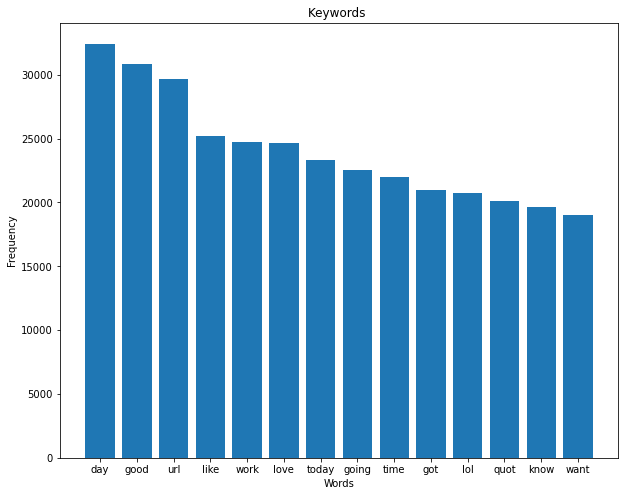

In [13]:
sorted_dic = sorted_dic[1:15]
xs, ys = [*zip(*sorted_dic)]
plt.figure(figsize=(10,8))
plt.bar(xs, ys)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Keywords ')
plt.show()